### UC_Boulder Unsupervised Learning CSCA 5632 Final Project

#### Project Title: 
Predictive Maintance of Milling Machines to predict 5 common failure modes.

#### Objective:
Implement clustering or sequence mining techniques to analyze time-series sensor data from a milling machine. The goal is find patterns that can help in predicting when maintenance is needed to prevent failures. In this notebook we will use Milling machine sensor hueristics such as speed, tempreture, RPM, machine type and operating temperature to predict possibility of a failure mode, There are 5 categries of failure for this project.
* Tool wear failure (TWF):
* Heat dissipation failure (HDF)
* Power failure (PWF):
* Overstrain failure (OSF): 
* Random failures (RNF):

#### Dataset:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74:.
csv file downloaded from --> Kaggle (https://www.kaggle.com/code/zakikurdya/predictive-maintenance/input)


# Code Start

In [87]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF, PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

import statsmodels.formula.api as smf
import statsmodels.api as sm

### Remove Warning msg wit local paths from the notebook outputs
import warnings
warnings.filterwarnings("ignore")



# Load the Data

In [88]:
raw_data_ = pd.read_csv('data/pm_mill.csv')
print(raw_data_.info())
raw_data_.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UDI                    10000 non-null  int64  
 1   Product_ID             10000 non-null  object 
 2   Type                   10000 non-null  object 
 3   Air_temperature_K      10000 non-null  float64
 4   Process_temperature_K  10000 non-null  float64
 5   Rotational_speed_rpm   10000 non-null  int64  
 6   Torque_Nm              10000 non-null  float64
 7   Tool_wear_min          10000 non-null  int64  
 8   Machine_failure        10000 non-null  int64  
 9   TWF                    10000 non-null  int64  
 10  HDF                    10000 non-null  int64  
 11  PWF                    10000 non-null  int64  
 12  OSF                    10000 non-null  int64  
 13  RNF                    10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ M

,UDI,Product_ID,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


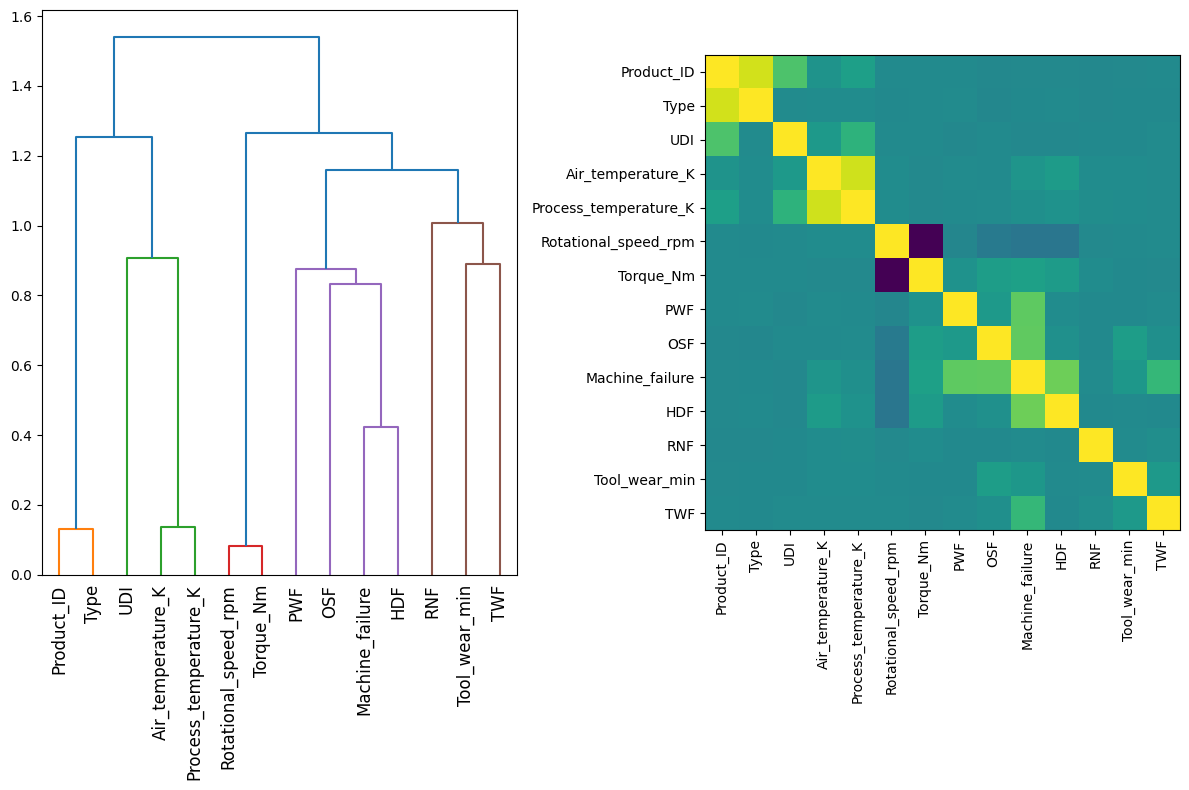

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(raw_data_).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=raw_data_.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

#### Basic Analysis
We can see that there is minimum correlation between the data columns. It is also supprising there is not a full overlap betweem machine failure and the failure modes. 

So lets investigate further, but first seeing how many unique machine types there are if they add value to this analysis.

10000


<Axes: >

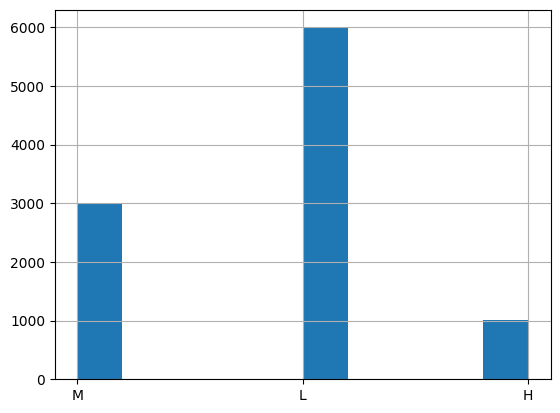

In [90]:
count = raw_data_['Product_ID'].unique()
print(len(count))
raw_data_['Type'].hist()

##### Input Data analysis

 
** The training data from publication consists of 10000 Rows of data, there are 13 columns. Other than the Product_ID and type all other data in the set are numerical with various magnitutde ranges. So they will need to be normalized, and the none-numerica data converted to Some numeric 

* 0   UDI                    10000 non-null  int64  
* 1   Product_ID             10000 non-null  object 
* 2   Type                   10000 non-null  object 
* 3   Air_temperature_K      10000 non-null  float64
* 4   Process_temperature_K  10000 non-null  float64
* 5   Rotational_speed_rpm   10000 non-null  int64  
* 6   Torque_Nm              10000 non-null  float64
* 7   Tool_wear_min          10000 non-null  int64  
* 8   Machine_failure        10000 non-null  int64  
* 9   TWF                    10000 non-null  int64  
* 10  HDF                    10000 non-null  int64  
* 11  PWF                    10000 non-null  int64  
* 12  OSF                    10000 non-null  int64  
* 13  RNF                    10000 non-null  int64   

** We will need to use the trian-test-split method to make sure we have test samples to test the mdoel, that will be done after data cleaning.


As we can see the Product ID does not have much value as the Product IDs are not a finite category. So we can drop that column. We should also change M L H of the type to a numeric value. We should also not there is 6 times as many samples of L as there are H and twice as many samples of L as M. Lets also look at if there are outliers or data with too much leverage to bias the models using OLS. We have also determined, we can drop Product_ID from this set as it does not add diffrentiation to the training. 

In [91]:
model =  smf.ols(formula='Machine_failure~Tool_wear_min+Torque_Nm+Air_temperature_K+Rotational_speed_rpm+Process_temperature_K', data=raw_data_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Machine_failure   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     283.7
Date:                Sat, 27 Apr 2024   Prob (F-statistic):          1.16e-284
Time:                        21:30:27   Log-Likelihood:                 3568.3
No. Observations:               10000   AIC:                            -7125.
Df Residuals:                    9994   BIC:                            -7081.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.29

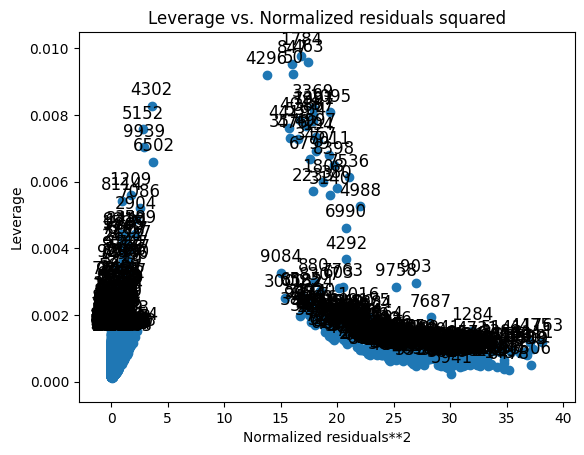

In [92]:
sm.graphics.plot_leverage_resid2(model)
plt.show()

### Data Cleaning
The data was mostly cleaned with no NaN or missing values in rows, however, data like Prooduct_ID offered no net new information as they were uique to each row, so it will be dropped from the dataset. The leverage plot showed that there are no outliers per say in this dataset, so no rows were removed. The ID column was alsoo converted to a numeric value using 0, 0.5, and 1 for each of M,L, and H

In [93]:
raw_data_["Type"] = raw_data_["Type"].replace({'M': 0, 'L': 0.5, 'H': 1}).astype(float)
raw_data_=raw_data_.drop('Product_ID', axis=1)
y_data = raw_data_[['Machine_failure', 'RNF',  'TWF', 'HDF', 'PWF',  'OSF']]
X_data = raw_data_.drop(['Machine_failure', 'RNF',  'TWF', 'HDF', 'PWF',  'OSF'], axis = 1)

In [94]:
print (X_data.info())
display(X_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UDI                    10000 non-null  int64  
 1   Type                   10000 non-null  float64
 2   Air_temperature_K      10000 non-null  float64
 3   Process_temperature_K  10000 non-null  float64
 4   Rotational_speed_rpm   10000 non-null  int64  
 5   Torque_Nm              10000 non-null  float64
 6   Tool_wear_min          10000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 547.0 KB
None


,UDI,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min
0,1,0.0,298.1,308.6,1551,42.8,0
1,2,0.5,298.2,308.7,1408,46.3,3
2,3,0.5,298.1,308.5,1498,49.4,5
3,4,0.5,298.2,308.6,1433,39.5,7
4,5,0.5,298.2,308.7,1408,40.0,9
...,...,...,...,...,...,...,...
9995,9996,0.0,298.8,308.4,1604,29.5,14
9996,9997,1.0,298.9,308.4,1632,31.8,17
9997,9998,0.0,299.0,308.6,1645,33.4,22
9998,9999,1.0,299.0,308.7,1408,48.5,25


In [95]:
print (y_data.info())
display(y_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Machine_failure  10000 non-null  int64
 1   RNF              10000 non-null  int64
 2   TWF              10000 non-null  int64
 3   HDF              10000 non-null  int64
 4   PWF              10000 non-null  int64
 5   OSF              10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB
None


,Machine_failure,RNF,TWF,HDF,PWF,OSF
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
9995,0,0,0,0,0,0
9996,0,0,0,0,0,0
9997,0,0,0,0,0,0
9998,0,0,0,0,0,0


Lets now normalize all the columns to be between 0-1. We will do this by min max normalization

In [96]:
X_data=(X_data-X_data.min())/(X_data.max()-X_data.min())
n_clusters = 6 # Define 7 clusters fo each of 6 failure modes as well as non-failure status

In [97]:
X_data.describe(include='all')

,UDI,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.500000,0.400300,0.511405,0.531551,0.215818,0.497073,0.426684
std,0.288718,0.300115,0.217419,0.183177,0.104356,0.136936,0.251597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.326087,0.382716,0.148428,0.403846,0.209486
50%,0.500000,0.500000,0.521739,0.543210,0.194994,0.498626,0.426877
75%,0.750000,0.500000,0.673913,0.666667,0.258440,0.590659,0.640316
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Analysis

##### Lets look at the Data Manually to understand any obvious patterns
Lets also look at a sample of the data table to see if we can notice any outliers or discrepencies that we need to address. And as we see above there nothing obvious in the dataset.

##### Lets look at the best predictors using R2
* First we need to undertand which columps have the most correlation to the failure rate. We can use the r2.

In [98]:
best_predictor=''
best_r_squared=0
best_degree=1
for column in X_data.columns:
    X = X_data[column]
    X = sm.add_constant(X)
    model = sm.OLS(y_data['Machine_failure'],X)
    results = model.fit()
    print (column, " : ", results.rsquared)
    if results.rsquared > best_r_squared:
        best_r_squared = results.rsquared
        best_predictor = column

print ('Best Predictor')
print (best_predictor, " : ", best_r_squared)

UDI  :  0.0005240347612478491
Type  :  2.6548210723453813e-05
Air_temperature_K  :  0.006815441915584364
Process_temperature_K  :  0.001292112998622974
Rotational_speed_rpm  :  0.0019525404352788156
Torque_Nm  :  0.03660363896936447
Tool_wear_min  :  0.011119326873315516
Best Predictor
Torque_Nm  :  0.03660363896936447


#### Visualize the Data
As we can see above doing a simple linear regression analysis, none of the colums ar a good predictor of the failure mode. So lets visualize the data to understand any other patterns.

(array([9661.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         339.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

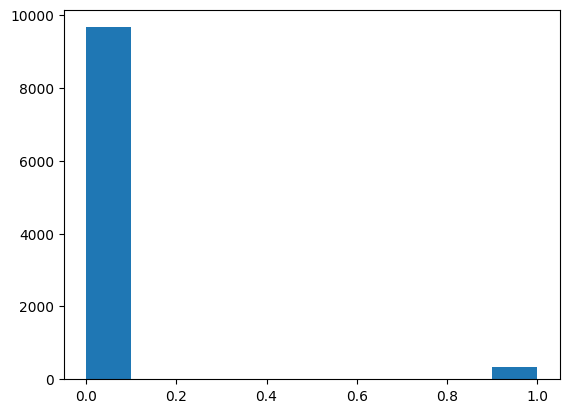

In [99]:
failure_types = y_data.loc[:, ['Machine_failure']]
total_failures = failure_types.sum(axis=1)
plt.hist(total_failures)

From the distribution we can see that there are large amounts of none failure to failure data in this data set. 

<Axes: title={'center': 'Torque Distribution'}, ylabel='Frequency'>

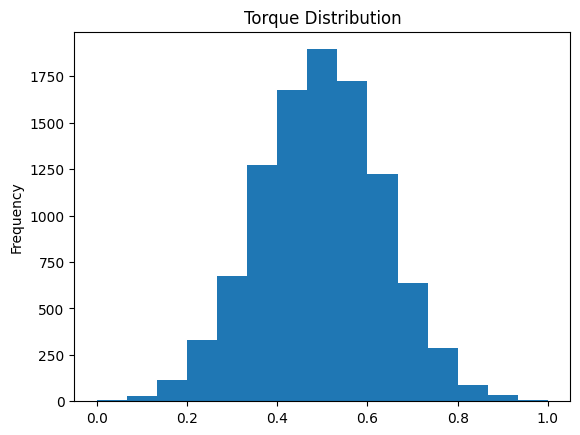

In [100]:
X_data['Torque_Nm'].plot.hist(title='Torque Distribution', bins=15)

<Axes: title={'center': 'Speed Distribution'}, ylabel='Frequency'>

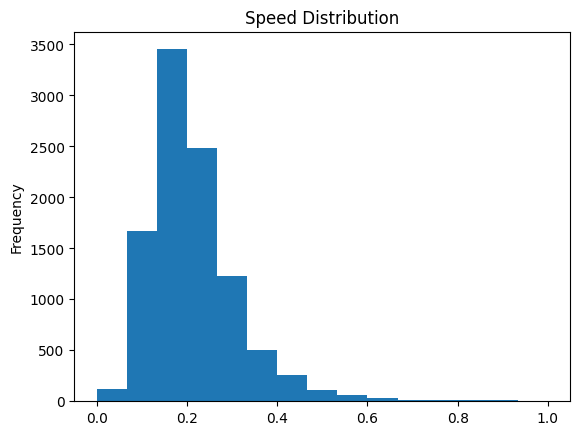

In [101]:
X_data['Rotational_speed_rpm'].plot.hist(title='Speed Distribution', bins=15)

<Axes: title={'center': 'Air temperature Distribution'}, ylabel='Frequency'>

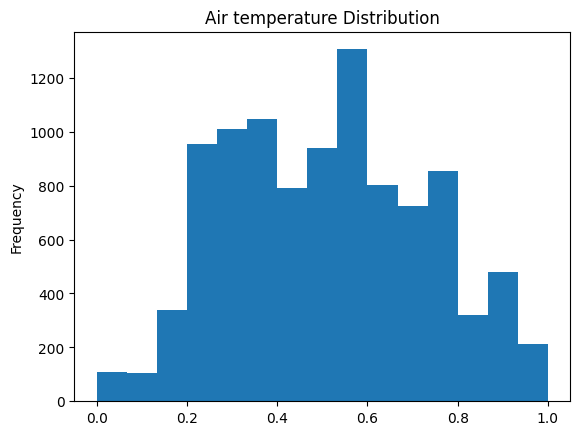

In [102]:
X_data['Air_temperature_K'].plot.hist(title='Air temperature Distribution', bins=15)

array([[<Axes: title={'center': 'Air_temperature_K'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'HDF'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'OSF'}, ylabel='[Machine_failure]'>],
       [<Axes: title={'center': 'PWF'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'Process_temperature_K'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'RNF'}, ylabel='[Machine_failure]'>],
       [<Axes: title={'center': 'Rotational_speed_rpm'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'TWF'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'Tool_wear_min'}, ylabel='[Machine_failure]'>],
       [<Axes: title={'center': 'Torque_Nm'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'Type'}, ylabel='[Machine_failure]'>,
        <Axes: title={'center': 'UDI'}, ylabel='[Machine_failure]'>]],
      dtype=object)

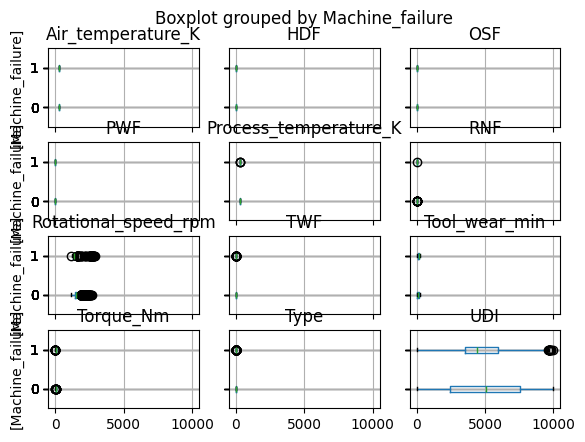

In [103]:
raw_data_.boxplot(by='Machine_failure', grid=True, vert=False)

<Axes: >

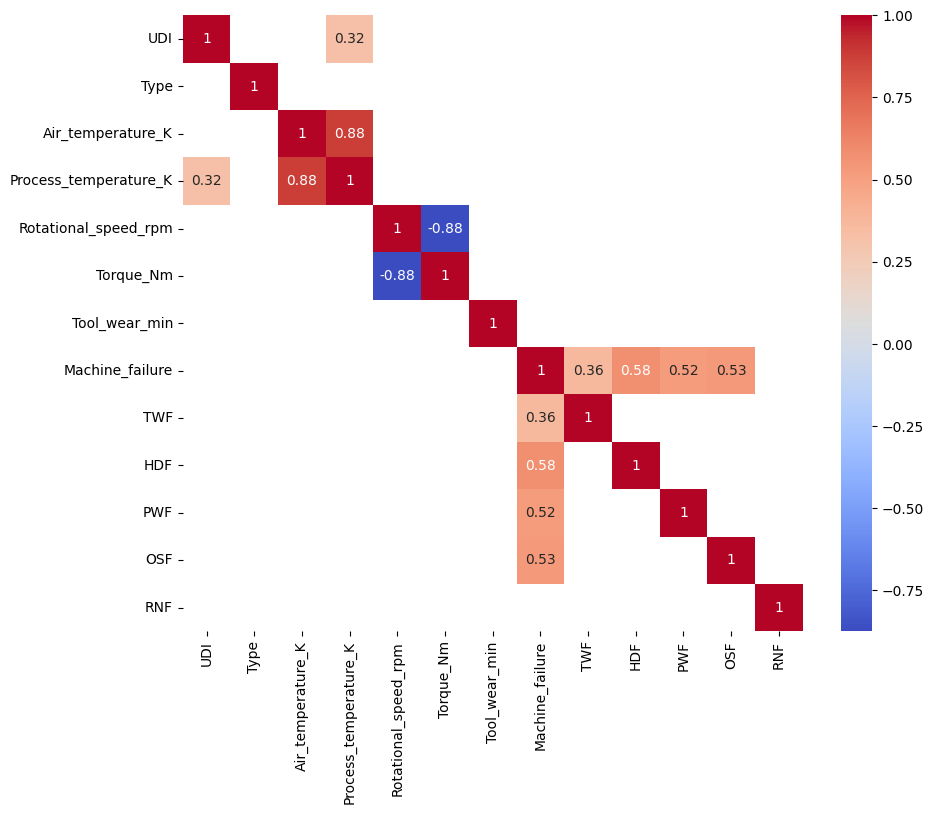

In [104]:
threshold = 0.3
correlation = raw_data_.corr()
matrix = correlation.where((abs(correlation) >= threshold)).isna()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap="coolwarm", annot=True, mask=matrix)

We can see that torque is correlated to RPM, which makes sense as Torque is inversly propotional to shaft Speed. Similarly Air temperature and Process tempreture are corellated, as ambient tempreture will affect process temperture's ability to perform heat exchange. 

Lets do pair plots to see if there are any observations to help in model selection

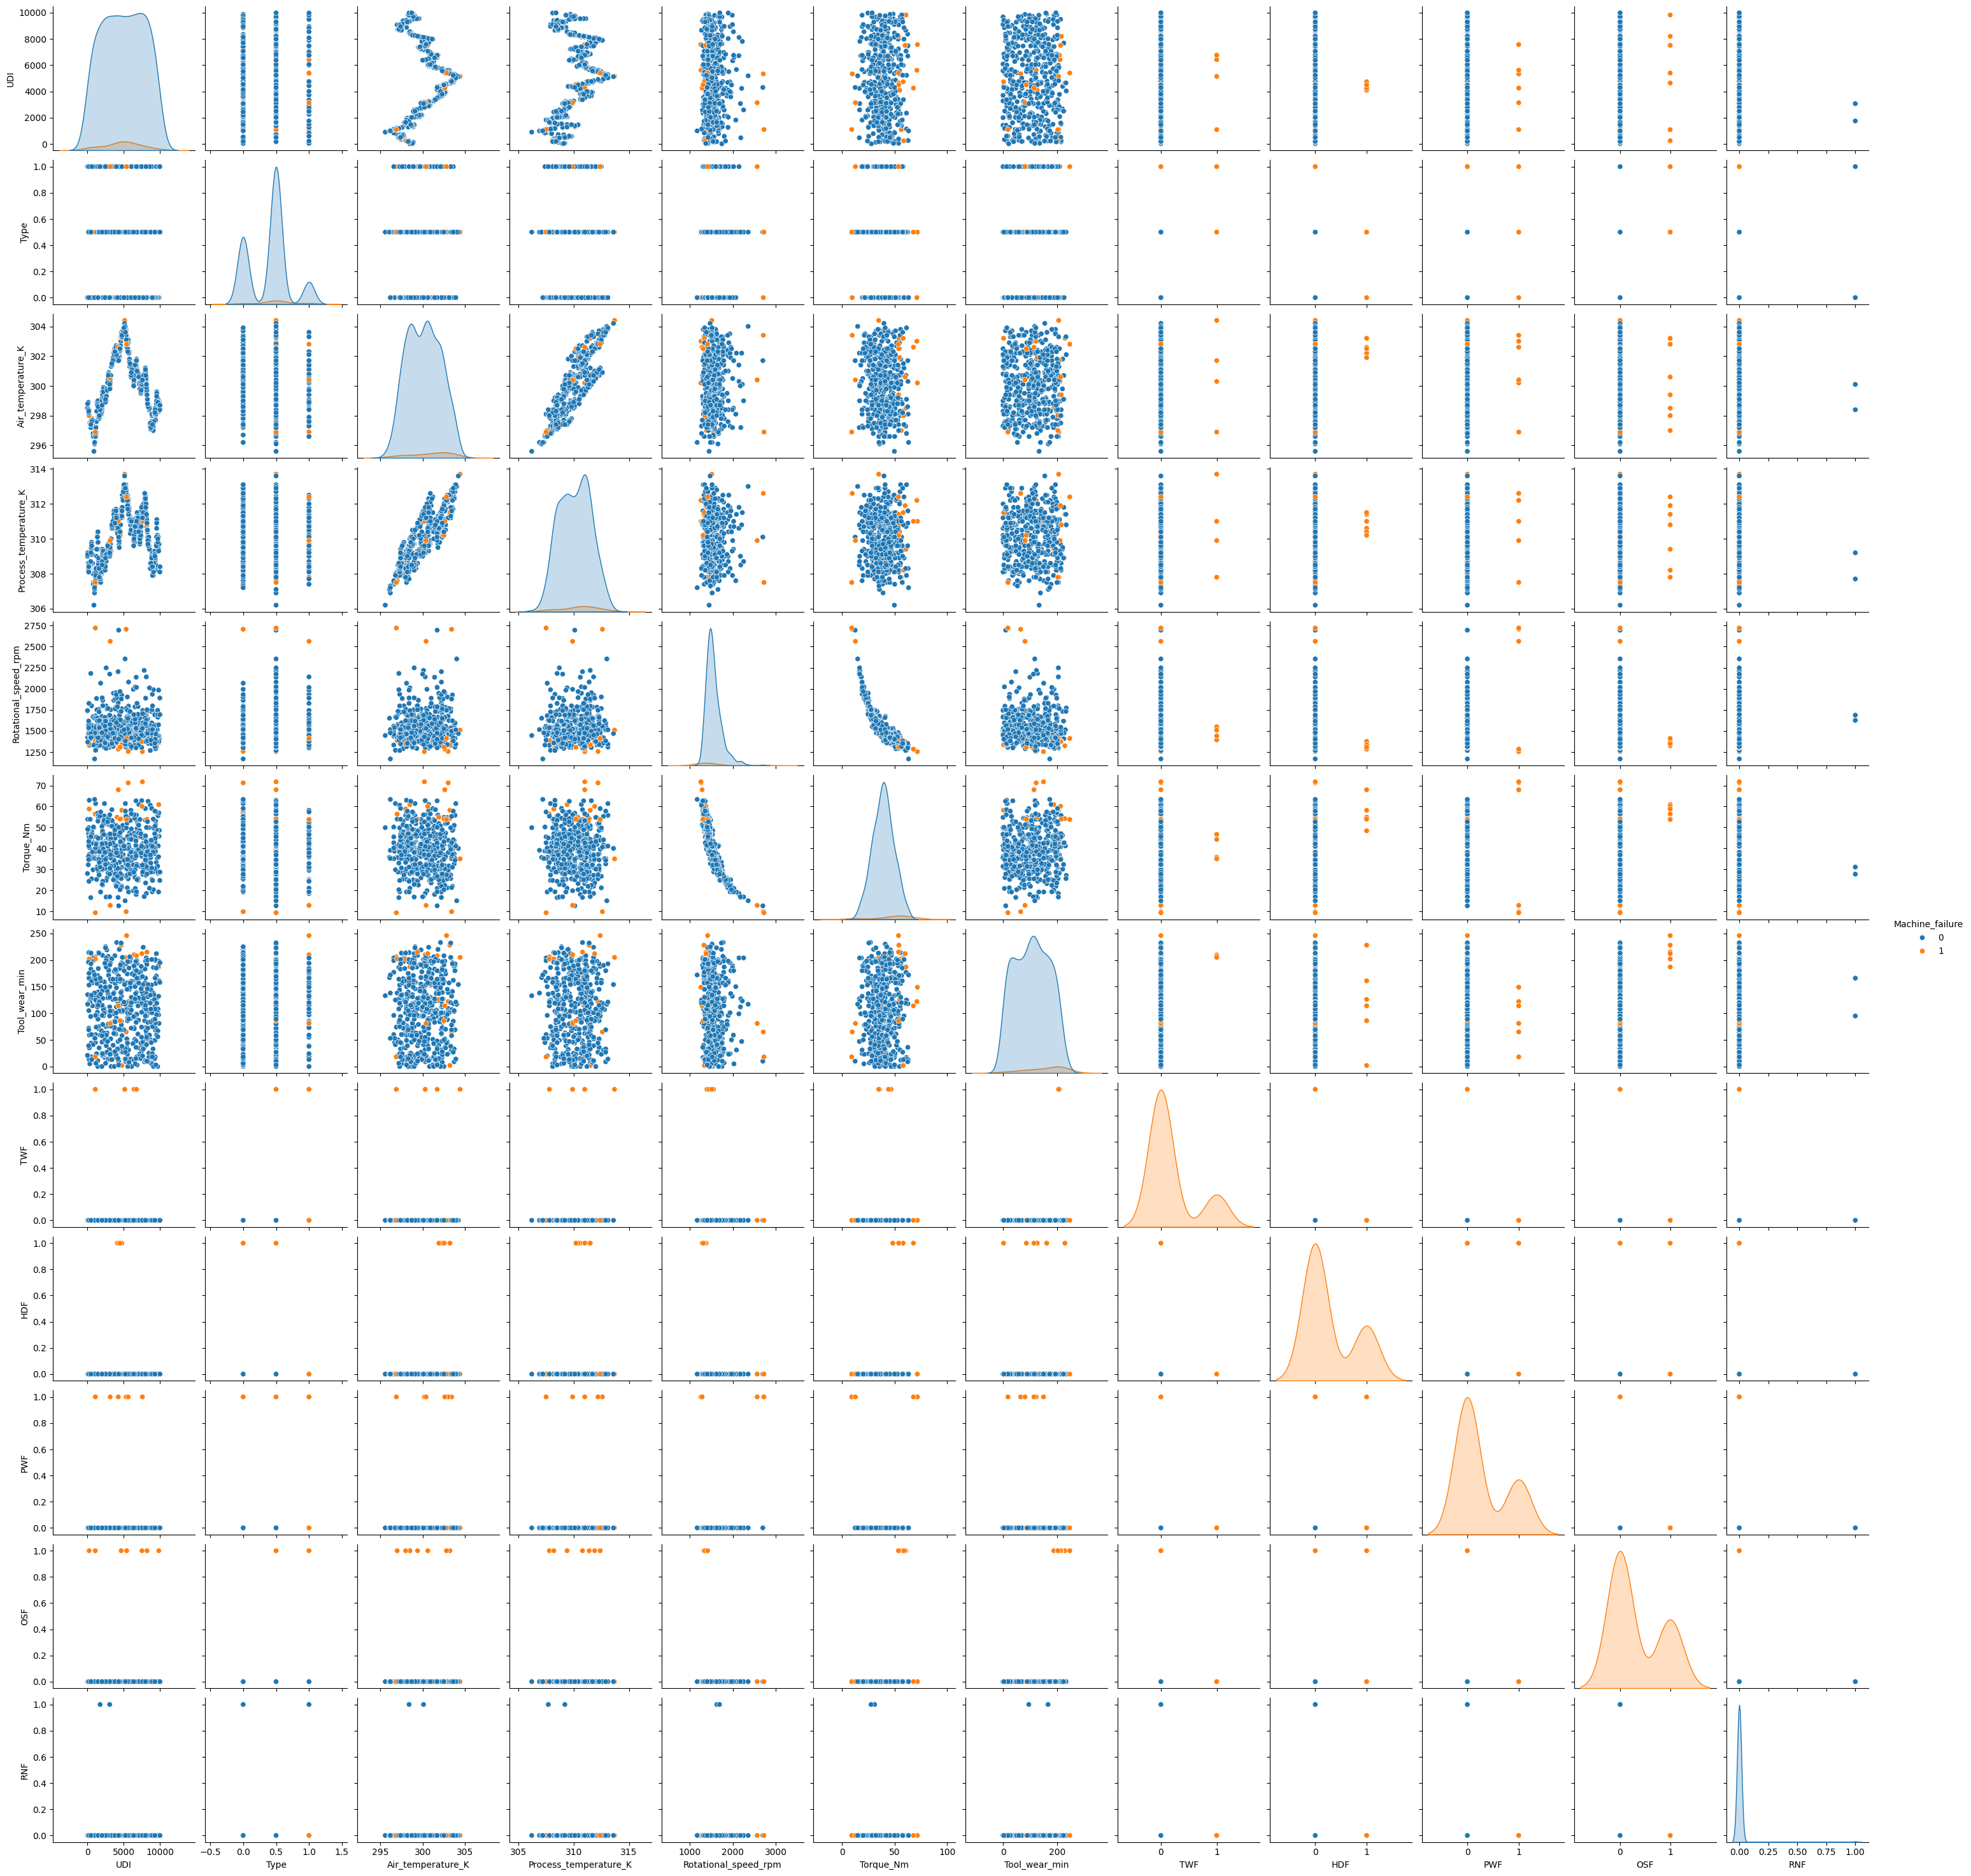

In [105]:
sns.pairplot(raw_data_.sample(frac=0.05), hue='Machine_failure')

### Exploratory Data Analysis
As we can see from the dataset above, with the histogram and pairplots, the corelation of the individual colum of data to the output is failry low. Indicating that anyone of these are not good predictors and thus must rely on a cumilative metric to act as a prediction.
* There were no null values to remove
* there was large bias toowards non-failure data (which makes sense as most cases would be non-failure modes)
* Thre were correlations between TOrque and RPM and the two temperatures.
#### Observations
We can also see the data is pretty well distributed, with good even distribution of samples in churn for all the categories.
Now Lets use gridsearch to train LogisticRegression

#### Model Evaluation
Each model tried contains the relative accuracy scores in line and area anaylsed in line as wlel. 

#### Models

As we are deaing a categorization problem, models we will evalaute are PCA, NMF, and KNearest Clustering
●We can see that there are collinearity between the data set. To reduce computational complexty these data's were removed from training and testing Data.
* Based on the R2 method above, you can see the feature importance below.
* Corelated data were removed from the trainind and test data set
* No new models outside of what was learned in class was tried here

First Lets split the Data in to training and Testing Data Set

<Axes: >

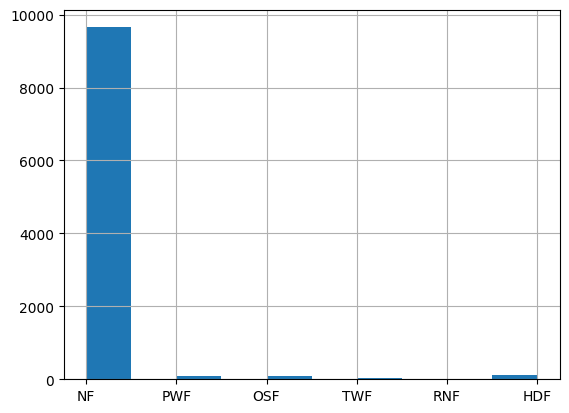

In [106]:
master_look_up_table = {"TWF": 5, "HDF": 4, "PWF": 3, "OSF":2, "RNF":1, "NF":0}

y_data['Labels'] = "NF"

y_data['Labels'] = y_data.apply(lambda row: 'NF' if row['Machine_failure'] < 1 else row['Labels'], axis=1)
y_data['Labels'] = y_data.apply(lambda row: 'TWF' if row['TWF'] > 0 else row['Labels'], axis=1)
y_data['Labels'] = y_data.apply(lambda row: 'PWF' if row['PWF'] > 0 else row['Labels'], axis=1)
y_data['Labels'] = y_data.apply(lambda row: 'OSF' if row['OSF'] > 0 else row['Labels'], axis=1)
y_data['Labels'] = y_data.apply(lambda row: 'RNF' if row['RNF'] > 0 else row['Labels'], axis=1)
y_data['Labels'] = y_data.apply(lambda row: 'HDF' if row['HDF'] > 0 else row['Labels'], axis=1)

y_data['Numeric_Labels']=y_data['Labels']

y_data['Numeric_Labels'] = y_data['Numeric_Labels'].replace(master_look_up_table).astype(int)


y_data.Labels.hist()

In [107]:
X_data = X_data.drop({'Rotational_speed_rpm', 'Air_temperature_K'}, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [108]:
import itertools

def label_permute_compare(ytdf,yp,n=7):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    n = len(ytdf)
    assert (n == len(yp))
    
    block = itertools.permutations(range(n_clusters))
    
    max_accuracy = 0
    
    r_value = [(0,0,0,0,0,0),0]
    
    for b in block:
        count = 0
        accuracy = 0
        labels=np.array(b)
        for j in range(n):
            count = 1+count if (labels[yp[j]] == ytdf[j]) else count
        accuracy = count/n
        if accuracy > max_accuracy: 
            max_accuracy = accuracy
            r_value = [b, accuracy]
    return r_value 

##### Clustering

In [109]:
model_single = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
model_single = model_single.fit(X_train)

labelorder, acc_single = label_permute_compare(y_train['Numeric_Labels'].values, model_single.labels_)
print(labelorder, acc_single)
labelorder = np.array(labelorder)

modified_label = np.array([labelorder[model_single.labels_[i]] for i in range(len(model_single.labels_))])
print(modified_label)
print(y_train['Numeric_Labels'].values)
confusion_matrix(y_train['Numeric_Labels'].values,modified_label)

(0, 1, 4, 5, 3, 2) 0.5771641791044776
[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]


array([[3836,  669,    0,    0, 1952,    1],
       [   7,    3,    0,    0,    1,    0],
       [  55,    1,    1,    0,    6,    0],
       [  34,    1,    0,    1,   19,    0],
       [  53,    6,    0,    0,   26,    0],
       [  15,    3,    0,    0,   10,    0]], dtype=int64)

In [126]:
y_test_pred = model_single.fit_predict(X_test)
y_test_modified_label = np.array([labelorder[y_test_pred[i]] for i in range(len(y_test_pred))])
print('Accuracy Score:',accuracy_score(y_test['Numeric_Labels'].values,y_test_modified_label))


confusion_matrix(y_test['Numeric_Labels'].values,y_test_modified_label)

Accuracy Score: 0.005757575757575757


array([[   0,    1,  964, 1921,  308,    0],
       [   0,    0,    1,    6,    1,    0],
       [   0,    0,    2,   26,    1,    0],
       [   1,    0,    6,   15,    2,    1],
       [   0,    0,    5,   23,    2,    0],
       [   0,    0,    2,    9,    3,    0]], dtype=int64)

#### KMeans

In [123]:
kmeans = KMeans(init="k-means++", n_clusters=n_clusters,  n_init=100, max_iter=3000, tol=0.00001,  verbose=0, random_state=None, copy_x=True,  algorithm='lloyd')
kmeans.fit(X_train)
y_train_pred = kmeans.fit_predict(X_train)

labelorder, acc_single = label_permute_compare(y_train['Numeric_Labels'].values, y_train_pred)
#print(labelorder, acc_single)
labelorder = np.array(labelorder)

y_train_modified_label = np.array([labelorder[y_train_pred[i]] for i in range(len(y_train_pred))])
print('Accuracy Score:',accuracy_score(y_train['Numeric_Labels'].values,y_train_modified_label))


confusion_matrix(y_train['Numeric_Labels'].values,y_train_modified_label)


Accuracy Score: 0.23119402985074627


array([[1466,  501, 1205,  882, 1334, 1070],
       [   3,    2,    2,    1,    3,    0],
       [  18,    1,   37,    2,    0,    5],
       [  15,    1,    4,   10,   15,   10],
       [   0,    6,   24,   17,   29,    9],
       [   3,    2,   13,    5,    0,    5]], dtype=int64)

In [124]:
y_test_pred = kmeans.predict(X_test)
y_test_modified_label = np.array([labelorder[y_test_pred[i]] for i in range(len(y_test_pred))])
print('Accuracy Score:',accuracy_score(y_test['Numeric_Labels'].values,y_test_modified_label))


confusion_matrix(y_test['Numeric_Labels'].values,y_test_modified_label)


Accuracy Score: 0.23303030303030303


array([[735, 218, 653, 427, 624, 537],
       [  1,   1,   5,   1,   0,   0],
       [ 10,   1,  16,   1,   0,   1],
       [  8,   2,   3,   4,   5,   3],
       [  2,   2,   9,   4,  12,   1],
       [  2,   2,   8,   1,   0,   1]], dtype=int64)

In [112]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [113]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X_train, labels=y_train['Numeric_Labels'])

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X_train, labels=y_train['Numeric_Labels'])

pca = PCA(n_components=5).fit(X_train)
kmeans = KMeans(init=pca.components_, n_clusters=5, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X_train, labels=y_train['Numeric_Labels'])

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.040s	17312	0.090	0.010	0.019	-0.001	0.017	0.242
random   	0.048s	17309	0.087	0.010	0.018	-0.001	0.016	0.218
PCA-based	0.010s	19243	0.104	0.014	0.024	-0.000	0.023	0.163
__________________________________________________________________________________


The following code is taken from Sklearn to visualize the clusters.
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

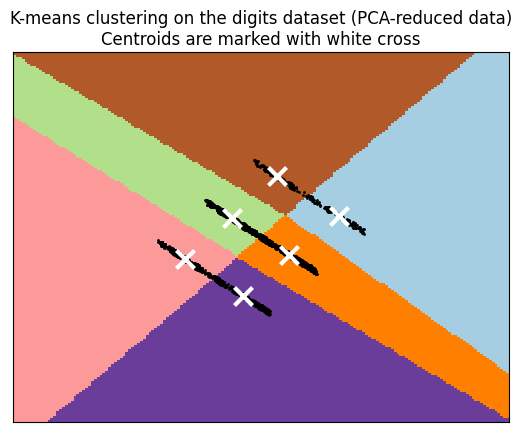

In [114]:
reduced_data = PCA(n_components=2).fit_transform(X_test)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Lets try NMF with max label fit

In [115]:
nmf = NMF(n_components=n_clusters, init='random', random_state=0)
W = nmf.fit_transform(X_train.T)
H = nmf.components_

max_index = np.argmax(H,axis=0)

y_train_pred = np.array(max_index)

labelorder, acc_single = label_permute_compare(y_train['Numeric_Labels'].values, y_train_pred)
labelorder = np.array(labelorder)

y_modified_label = np.array([labelorder[y_train_pred[i]] for i in range(len(y_train_pred))])
print('Accuracy Score:',accuracy_score(y_train['Numeric_Labels'].values,y_modified_label))

confusion_matrix(y_train['Numeric_Labels'].values,y_modified_label)


Accuracy Score: 0.2637313432835821


array([[1670,  869, 1259,  960, 1309,  391],
       [   0,    3,    1,    1,    6,    0],
       [  14,    1,   34,    3,   11,    0],
       [   5,    6,    4,    9,   30,    1],
       [   0,    6,   21,    5,   51,    2],
       [   2,    3,   22,    1,    0,    0]], dtype=int64)

In [116]:
y_predict = nmf.fit(X_test.T).components_
max_index = np.argmax(y_predict,axis=0)
y_test_pred = np.array(max_index)
y_test_label = np.array([labelorder[y_test_pred[i]] for i in range(len(y_test_pred))])

print('Accuracy Score:',accuracy_score(y_test['Numeric_Labels'].values,y_test_label))

confusion_matrix(y_test['Numeric_Labels'].values,y_test_label)


Accuracy Score: 0.2396969696969697


array([[786, 463, 515, 422, 732, 276],
       [  3,   2,   1,   1,   0,   1],
       [ 25,   0,   0,   0,   4,   0],
       [  3,   3,   5,   3,   4,   7],
       [  5,   1,   6,   2,   0,  16],
       [ 10,   3,   0,   1,   0,   0]], dtype=int64)

#### Supervised Learning For Comaprison

In [117]:
def tune_model(clf, param_grid, X_train, y_train, X_val, y_val):    
    grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3, n_jobs=None) 
    grid.fit(X_train, y_train) 
    print('Best params:', grid.best_params_) 
    grid_pred = grid.predict(X_val) 
    print('val score:', grid.score(X_val, y_val))    
    print(classification_report(y_val, grid_pred))  

tune_model(SVC(), 
                     {'C': [0.1, 1, 10, 100],  
                      'gamma':['scale', 'auto'],
                      'kernel': ['linear', 'rbf']}, 
                      X_train, y_train['Numeric_Labels'].values, X_test, y_test['Numeric_Labels'].values)  

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.964 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.964 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.964 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.963 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.963 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.964 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.964 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.964 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.963 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.963 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.964 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear;

#### Results and Analysis
Some questions to consider:
* As we can see from the various techniques used to cluster the data, none provided an accuracy greater than 0.3 on the test data. 
* SVC on the other hand achieved accuracy of 0.98. As this is a linear technique, it leads me to belive the accuracy of the Clustering techniques can be greatly improved with the right hyper parameters. As the polynomial SVC is using should result in distincy Hyperplanes we can use to slice.
* Only Techiques from class were explored here so overall the accuracy score was not improved using unsupervised learning.

AgglomerativeClustering: Train Accuracy = 0.58, Test Accuracy = 0.0057
KMeans: Train Accuracy= 0.58, Test Accuracy= 0.27
NMF: Train Accuracy= 0.27, Test Accuracy= 0.22

#### Discussion and Conclusion

In this report we looked at the effectiveness of categorizing various preventative maintance modes for milling machines using machine sensor parameters. We saw from the tuning and categorization above, the tehcniques explored did not yield results bettern than 0.3 on test data. SVC on the other hand was able to achieve 0.98 accuracy. This leads to the conclusion there must be some form of hyper parameters than can further improve the resluts. These were not explored further in this notebook.
